In [1]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [2]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

from energy_centre import EnergyCentre

## Scenario 1 - Direct electric

In [3]:
timestep = '0.5H'
timestamp_from = '2019-01-01 00:00:00'
timestamp_to = '2019-12-31 23:30:00'
DE = EnergyCentre(timestep=timestep, timestamp_from=timestamp_from, timestamp_to=timestamp_to)
DE.get_data_scottish_borders()
DE.add_bus('heat')
DE.add_bus('elec')
DE.add_heat_demand()
DE.add_elec_demand()
DE.add_grid_connection()
DE.add_resistive_heater(extendable=True)

# run LOPF
DE.network.lopf(DE.network.snapshots,
                    solver_name="gurobi",
                #   pyomo=False,
                #   keep_shadowprices=True,
                    )

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x35042_copy
  Lower bound: -129999039804.49892
  Upper bound: -129999039804.49892
  Number of objectives: 1
  Number of constraints: 70081
  Number of variables: 35042
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 35042
  Number of nonzeros: 105121
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminati

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

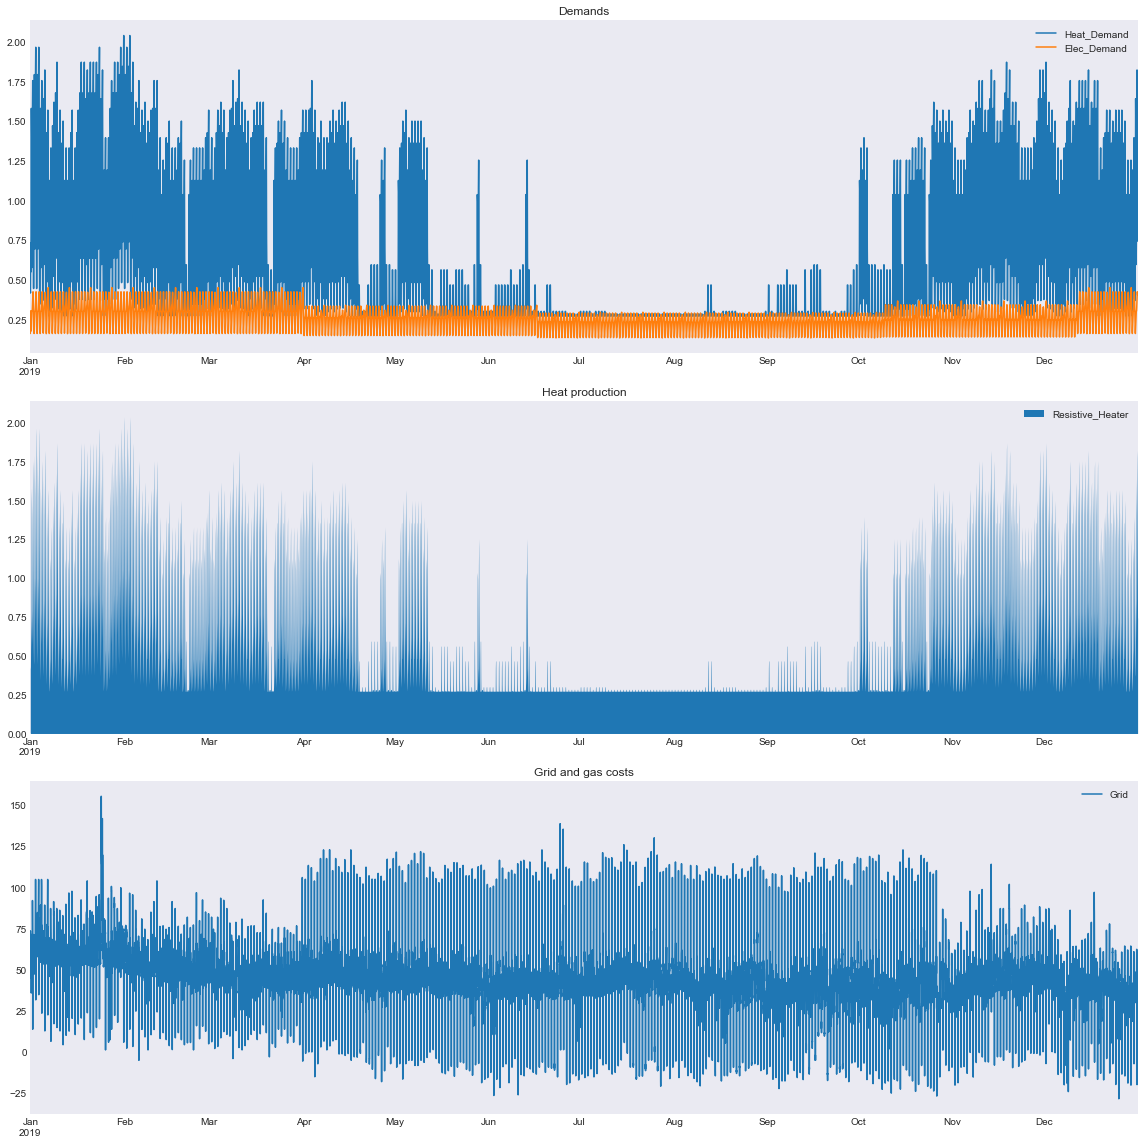

In [4]:
# ScotBord.network.generators_t.p['Heat_Pump'] = ScotBord.network.links_t.p1.Heat_Pump * -1
DE.network.generators_t.p['Resistive_Heater'] = DE.network.links_t.p1.Resistive_Heater * -1
# ScotBord.network.generators_t.marginal_cost['Gas_Boiler'] = ScotBord.network.generators.marginal_cost.Gas_Boiler

fig, axs = plt.subplots(3, 1, figsize=(16, 16))

DE.network.loads_t.p.rename_axis('').plot(ax=axs[0], title='Demands')
DE.network.generators_t.p.rename_axis('').drop(columns=['Grid']).plot.area(ax=axs[1], linewidth=0, title='Heat production')
DE.network.generators_t.marginal_cost.rename_axis('').plot(ax=axs[2], title='Grid and gas costs')
# DirectElectric.network.stores_t.e.rename_axis('').plot(ax=axs[3], title='Storages state of charge')

for ax in axs:
    ax.legend()
plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Heat production'}>

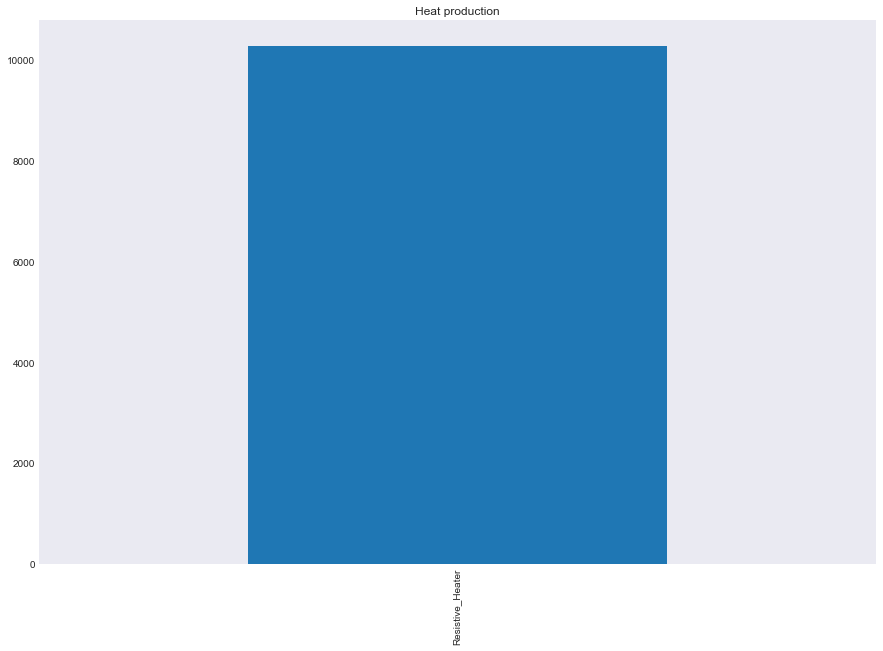

In [5]:
DE.network.generators_t.p.rename_axis('').drop(columns=['Grid']).sum().plot.bar(figsize=(15,10), title='Heat production')

Total carbon emissions kgCO2

In [6]:
DE.carbon_calculator(DE.network.generators_t.p.Grid)
DE.total_carbon_emissions = DE.carbon_emissions.sum().round(2)
DE.total_carbon_emissions

933927.3

Total costs £

In [7]:
DE.total_costs = DE.network.objective + DE.network.objective_constant
DE.total_costs

960195.501083374

Capex £

In [8]:
DE.capex = DE.network.links.p_nom_opt.Resistive_Heater * DE.network.links.capital_cost.Resistive_Heater
DE.capex

264940.0

Opex £

In [9]:
DE.opex = DE.total_costs - DE.capex
DE.opex

695255.501083374

## Scenario 2 - Direct electric and heat pump

In [10]:
timestep = '0.5H'
timestamp_from = '2019-01-01 00:00:00'
timestamp_to = '2019-12-31 23:30:00'
DE_HP = EnergyCentre(timestep=timestep, timestamp_from=timestamp_from, timestamp_to=timestamp_to)
DE_HP.get_data_scottish_borders()
DE_HP.add_bus('heat')
DE_HP.add_bus('elec')
DE_HP.add_heat_demand()
DE_HP.add_elec_demand()
DE_HP.add_grid_connection()
DE_HP.add_resistive_heater(extendable=True)
DE_HP.add_heat_pump(extendable=True)

# run LOPF
DE_HP.network.lopf(DE_HP.network.snapshots,
                    solver_name="gurobi",
                #   pyomo=False,
                #   keep_shadowprices=True,
                    )

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x52563_copy
  Lower bound: -130003245601.91888
  Upper bound: -130003245601.91888
  Number of objectives: 1
  Number of constraints: 105121
  Number of variables: 52563
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 52563
  Number of nonzeros: 192721
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminat

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

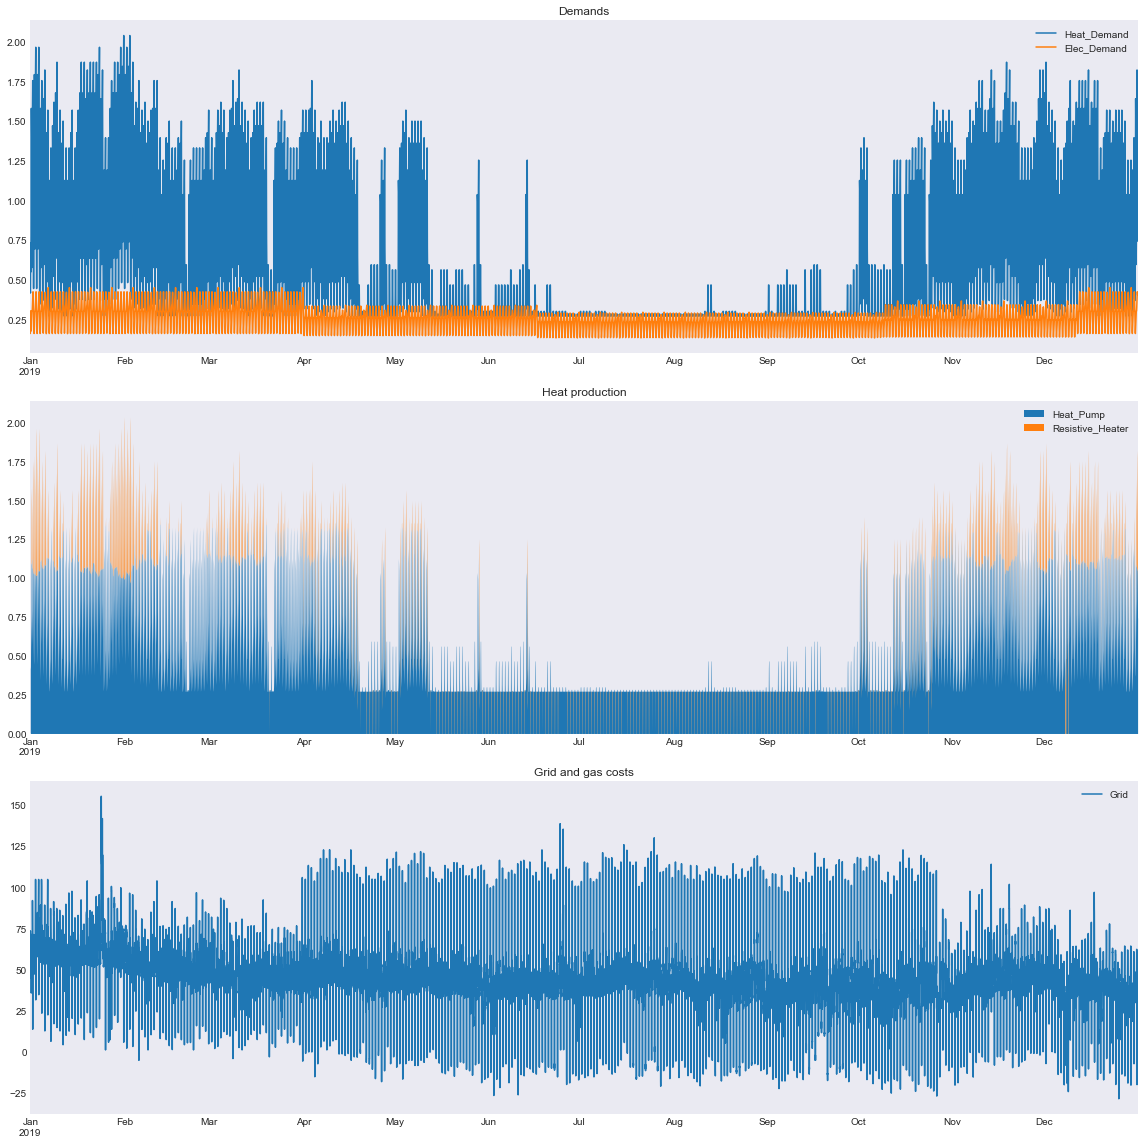

In [11]:
DE_HP.network.generators_t.p['Heat_Pump'] = DE_HP.network.links_t.p1.Heat_Pump * -1
DE_HP.network.generators_t.p['Resistive_Heater'] = DE_HP.network.links_t.p1.Resistive_Heater * -1
# ScotBord.network.generators_t.marginal_cost['Gas_Boiler'] = ScotBord.network.generators.marginal_cost.Gas_Boiler

fig, axs = plt.subplots(3, 1, figsize=(16, 16))

DE_HP.network.loads_t.p.rename_axis('').plot(ax=axs[0], title='Demands')
DE_HP.network.generators_t.p.rename_axis('').drop(columns=['Grid']).plot.area(ax=axs[1], linewidth=0, title='Heat production')
DE_HP.network.generators_t.marginal_cost.rename_axis('').plot(ax=axs[2], title='Grid and gas costs')
# DirectElectric.network.stores_t.e.rename_axis('').plot(ax=axs[3], title='Storages state of charge')

for ax in axs:
    ax.legend()
plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Heat production'}>

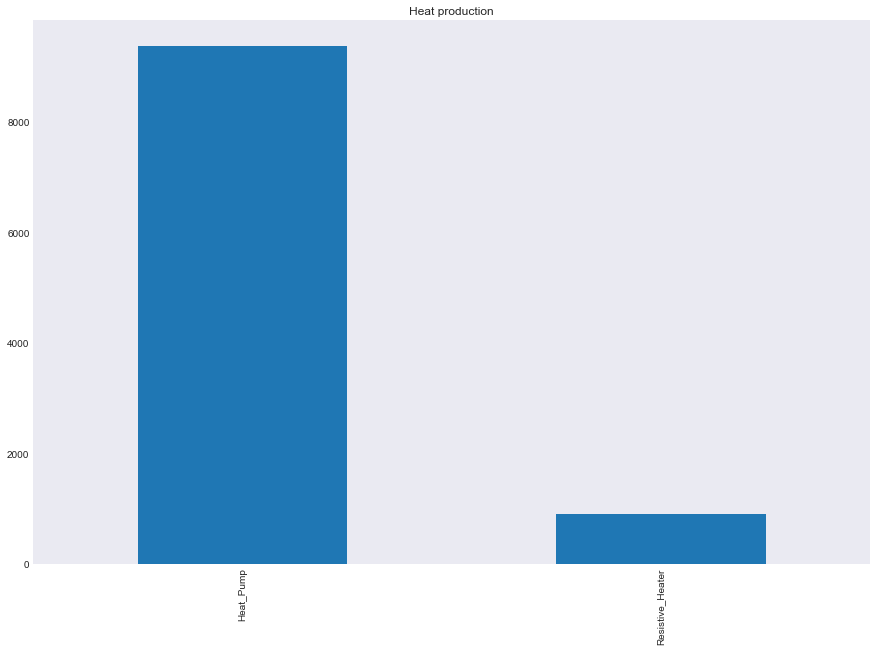

In [12]:
DE_HP.network.generators_t.p.rename_axis('').drop(columns=['Grid']).sum().plot.bar(figsize=(15,10), title='Heat production')

In [13]:
DE_HP.carbon_calculator(DE_HP.network.generators_t.p.Grid)
DE_HP.total_carbon_emissions = DE_HP.carbon_emissions.sum().round(2)
DE_HP.total_carbon_emissions

577978.26

In [14]:
DE_HP.total_costs = DE_HP.network.objective + DE_HP.network.objective_constant
DE_HP.total_costs

754398.0811157227

Capex £

In [15]:
DE_HP.capex = (DE_HP.network.links.p_nom_opt.Resistive_Heater * DE_HP.network.links.capital_cost.Resistive_Heater +
            DE_HP.network.links.p_nom_opt.Heat_Pump * DE_HP.network.links.capital_cost.Heat_Pump)
DE_HP.capex

335004.1265999465

Opex £

In [16]:
DE_HP.opex = DE_HP.total_costs - DE_HP.capex
DE_HP.opex

419393.95451577613

## Scenario 3 - Direct electric, heat pump, and short-term thermal storage

In [18]:
timestep = '0.5H'
timestamp_from = '2019-01-01 00:00:00'
timestamp_to = '2019-12-31 23:30:00'
DE_HP_STS = EnergyCentre(timestep=timestep, timestamp_from=timestamp_from, timestamp_to=timestamp_to)
DE_HP_STS.get_data_scottish_borders()
DE_HP_STS.add_bus('heat')
DE_HP_STS.add_bus('elec')
DE_HP_STS.add_heat_demand()
DE_HP_STS.add_elec_demand()
DE_HP_STS.add_grid_connection()
DE_HP_STS.add_resistive_heater(extendable=True)
DE_HP_STS.add_heat_pump(extendable=True)
DE_HP_STS.add_short_term_store(extendable=True)

# run LOPF
DE_HP_STS.network.lopf(DE_HP_STS.network.snapshots,
                    solver_name="gurobi",
                #   pyomo=False,
                #   keep_shadowprices=True,
                    )

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x122644_copy
  Lower bound: -130003440854.8101
  Upper bound: -130003440854.8101
  Number of objectives: 1
  Number of constraints: 245281
  Number of variables: 122644
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 122644
  Number of nonzeros: 455520
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termina

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

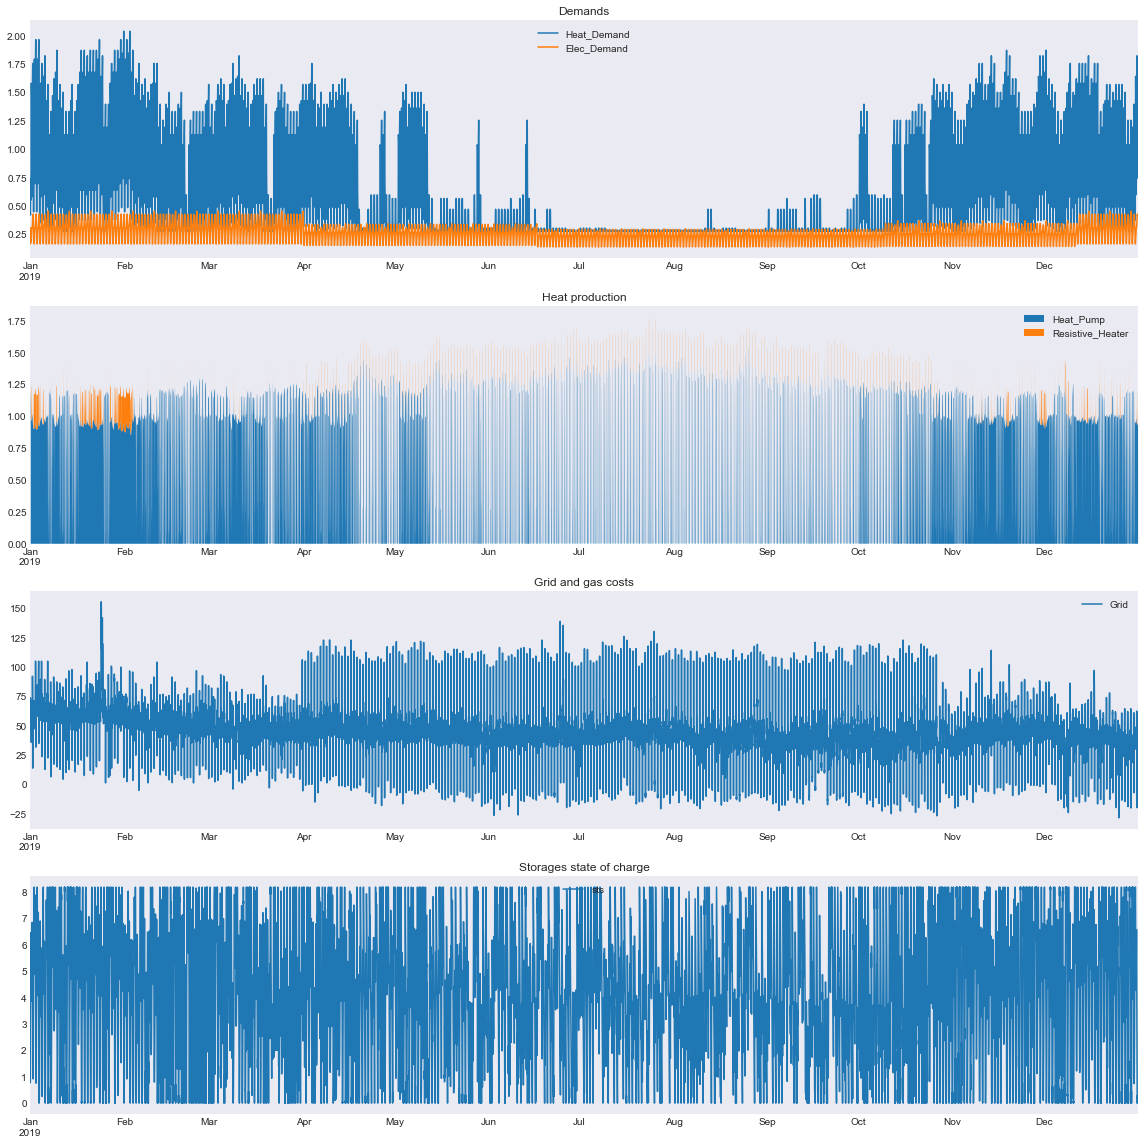

In [19]:
DE_HP_STS.network.generators_t.p['Heat_Pump'] = DE_HP_STS.network.links_t.p1.Heat_Pump * -1
DE_HP_STS.network.generators_t.p['Resistive_Heater'] = DE_HP_STS.network.links_t.p1.Resistive_Heater * -1
# ScotBord.network.generators_t.marginal_cost['Gas_Boiler'] = ScotBord.network.generators.marginal_cost.Gas_Boiler

fig, axs = plt.subplots(4, 1, figsize=(16, 16))

DE_HP_STS.network.loads_t.p.rename_axis('').plot(ax=axs[0], title='Demands')
DE_HP_STS.network.generators_t.p.rename_axis('').drop(columns=['Grid']).plot.area(ax=axs[1], linewidth=0, title='Heat production')
DE_HP_STS.network.generators_t.marginal_cost.rename_axis('').plot(ax=axs[2], title='Grid and gas costs')
DE_HP_STS.network.stores_t.e.rename_axis('').plot(ax=axs[3], title='Storages state of charge')

for ax in axs:
    ax.legend()
plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Heat production'}>

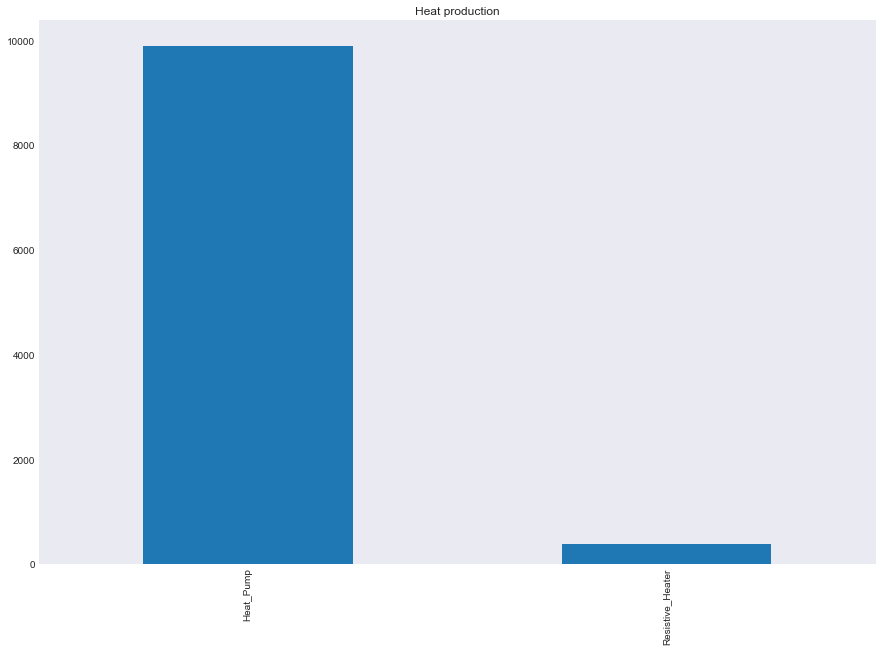

In [20]:
DE_HP_STS.network.generators_t.p.rename_axis('').drop(columns=['Grid']).sum().plot.bar(figsize=(15,10), title='Heat production')

In [21]:
DE_HP_STS.carbon_calculator(DE_HP_STS.network.generators_t.p.Grid)
DE_HP_STS.total_carbon_emissions = DE_HP_STS.carbon_emissions.sum().round(2)
DE_HP_STS.total_carbon_emissions

545655.23

In [22]:
DE_HP_STS.total_costs = DE_HP_STS.network.objective + DE_HP_STS.network.objective_constant
DE_HP_STS.total_costs

601145.1898956299

Capex £

In [23]:
DE_HP_STS.capex = (DE_HP_STS.network.links.p_nom_opt.Resistive_Heater * DE_HP_STS.network.links.capital_cost.Resistive_Heater +
                   DE_HP_STS.network.links.p_nom_opt.Heat_Pump * DE_HP_STS.network.links.capital_cost.Heat_Pump +
                   DE_HP_STS.network.stores.e_nom_opt.sts * DE_HP_STS.network.stores.capital_cost.sts)
DE_HP_STS.capex

234596.0135769643

Opex £

In [24]:
DE_HP_STS.opex = DE_HP_STS.total_costs - DE_HP_STS.capex
DE_HP_STS.opex

366549.1763186656

## Scenario 4 - Direct electric, heat pump, short-term thermal storage, and long-term thermal storage

In [25]:
timestep = '0.5H'
timestamp_from = '2019-01-01 00:00:00'
timestamp_to = '2019-12-31 23:30:00'
DE_HP_STS_LTS = EnergyCentre(timestep=timestep, timestamp_from=timestamp_from, timestamp_to=timestamp_to)
DE_HP_STS_LTS.get_data_scottish_borders()
DE_HP_STS_LTS.add_bus('heat')
DE_HP_STS_LTS.add_bus('elec')
DE_HP_STS_LTS.add_heat_demand()
DE_HP_STS_LTS.add_elec_demand()
DE_HP_STS_LTS.add_grid_connection()
DE_HP_STS_LTS.add_resistive_heater(extendable=True)
DE_HP_STS_LTS.add_heat_pump(extendable=True)
DE_HP_STS_LTS.add_short_term_store(extendable=True)
DE_HP_STS_LTS.add_long_term_store(extendable=True)

# run LOPF
DE_HP_STS_LTS.network.lopf(DE_HP_STS_LTS.network.snapshots,
                    solver_name="gurobi",
                #   pyomo=False,
                #   keep_shadowprices=True,
                    )

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x192725_copy
  Lower bound: -130003913277.80077
  Upper bound: -130003913277.80077
  Number of objectives: 1
  Number of constraints: 385441
  Number of variables: 192725
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 192725
  Number of nonzeros: 718319
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termi

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

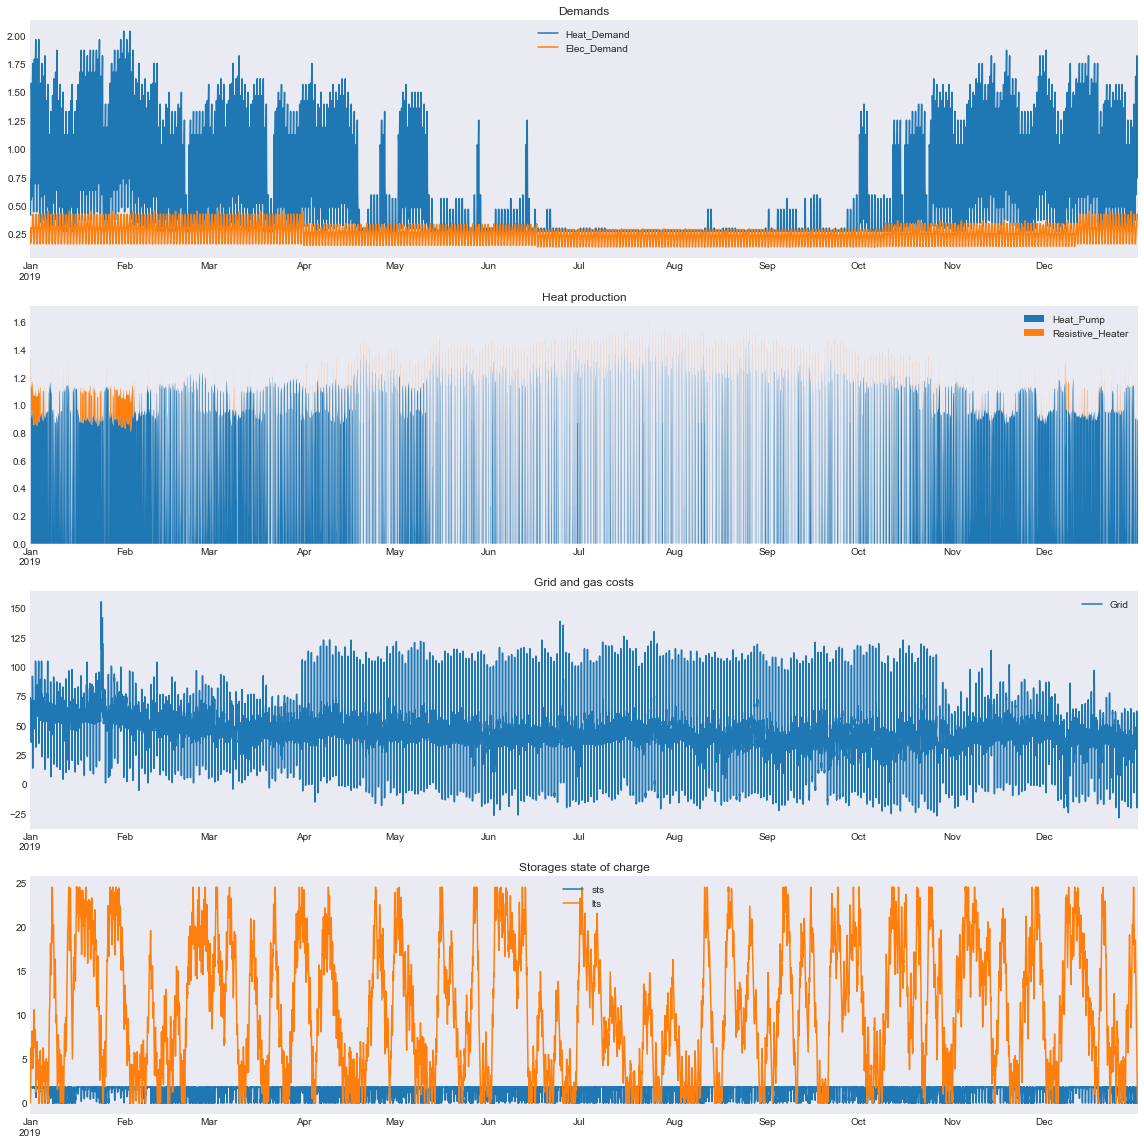

In [26]:
DE_HP_STS_LTS.network.generators_t.p['Heat_Pump'] = DE_HP_STS_LTS.network.links_t.p1.Heat_Pump * -1
DE_HP_STS_LTS.network.generators_t.p['Resistive_Heater'] = DE_HP_STS_LTS.network.links_t.p1.Resistive_Heater * -1
# ScotBord.network.generators_t.marginal_cost['Gas_Boiler'] = ScotBord.network.generators.marginal_cost.Gas_Boiler

fig, axs = plt.subplots(4, 1, figsize=(16, 16))

DE_HP_STS_LTS.network.loads_t.p.rename_axis('').plot(ax=axs[0], title='Demands')
DE_HP_STS_LTS.network.generators_t.p.rename_axis('').drop(columns=['Grid']).plot.area(ax=axs[1], linewidth=0, title='Heat production')
DE_HP_STS_LTS.network.generators_t.marginal_cost.rename_axis('').plot(ax=axs[2], title='Grid and gas costs')
DE_HP_STS_LTS.network.stores_t.e.rename_axis('').plot(ax=axs[3], title='Storages state of charge')

for ax in axs:
    ax.legend()
plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Heat production'}>

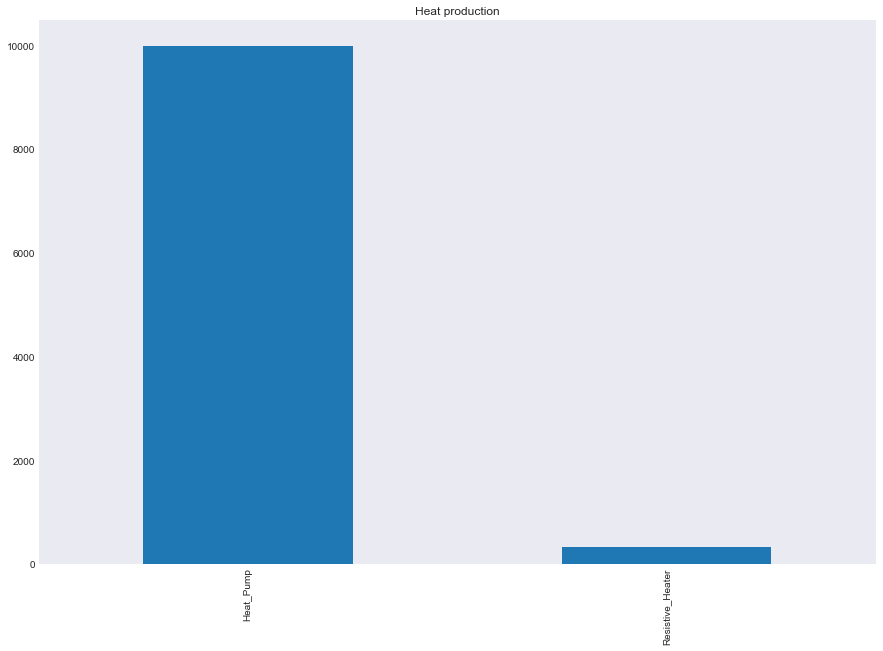

In [27]:
DE_HP_STS_LTS.network.generators_t.p.rename_axis('').drop(columns=['Grid']).sum().plot.bar(figsize=(15,10), title='Heat production')

In [28]:
DE_HP_STS_LTS.carbon_calculator(DE_HP_STS_LTS.network.generators_t.p.Grid)
DE_HP_STS_LTS.total_carbon_emissions = DE_HP_STS_LTS.carbon_emissions.sum().round(2)
DE_HP_STS_LTS.total_carbon_emissions

539674.24

In [29]:
DE_HP_STS_LTS.total_costs = DE_HP_STS_LTS.network.objective + DE_HP_STS_LTS.network.objective_constant
DE_HP_STS_LTS.total_costs

578722.1992340088

Capex £

In [30]:
DE_HP_STS_LTS.capex = (DE_HP_STS_LTS.network.links.p_nom_opt.Resistive_Heater * DE_HP_STS_LTS.network.links.capital_cost.Resistive_Heater +
                       DE_HP_STS_LTS.network.links.p_nom_opt.Heat_Pump * DE_HP_STS_LTS.network.links.capital_cost.Heat_Pump +
                       DE_HP_STS_LTS.network.stores.e_nom_opt.sts * DE_HP_STS_LTS.network.stores.capital_cost.sts +
                       DE_HP_STS_LTS.network.stores.e_nom_opt.lts * DE_HP_STS_LTS.network.stores.capital_cost.lts)
DE_HP_STS_LTS.capex

211507.9862996626

Opex £

In [31]:
DE_HP_STS_LTS.opex = DE_HP_STS_LTS.total_costs - DE_HP_STS_LTS.capex
DE_HP_STS_LTS.opex

367214.2129343462

## Scenario 5 - Curtailed wind discount

In [32]:
timestep = '0.5H'
timestamp_from = '2019-01-01 00:00:00'
timestamp_to = '2019-12-31 23:30:00'
CurtailedWind = EnergyCentre(timestep=timestep, timestamp_from=timestamp_from, timestamp_to=timestamp_to)
CurtailedWind.get_data_scottish_borders()

CurtailedWind.apply_constraint_discount()

CurtailedWind.add_bus('heat')
CurtailedWind.add_bus('elec')
CurtailedWind.add_heat_demand()
CurtailedWind.add_elec_demand()
CurtailedWind.add_grid_connection()
CurtailedWind.add_resistive_heater(extendable=True)
CurtailedWind.add_heat_pump(extendable=True)
CurtailedWind.add_short_term_store(extendable=True)
CurtailedWind.add_long_term_store(extendable=True)

# run LOPF
CurtailedWind.network.lopf(CurtailedWind.network.snapshots,
                    solver_name="gurobi",
                #   pyomo=False,
                #   keep_shadowprices=True,
                    )

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x192725_copy
  Lower bound: -130003932846.08553
  Upper bound: -130003932846.08553
  Number of objectives: 1
  Number of constraints: 385441
  Number of variables: 192725
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 192725
  Number of nonzeros: 718319
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termi

(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

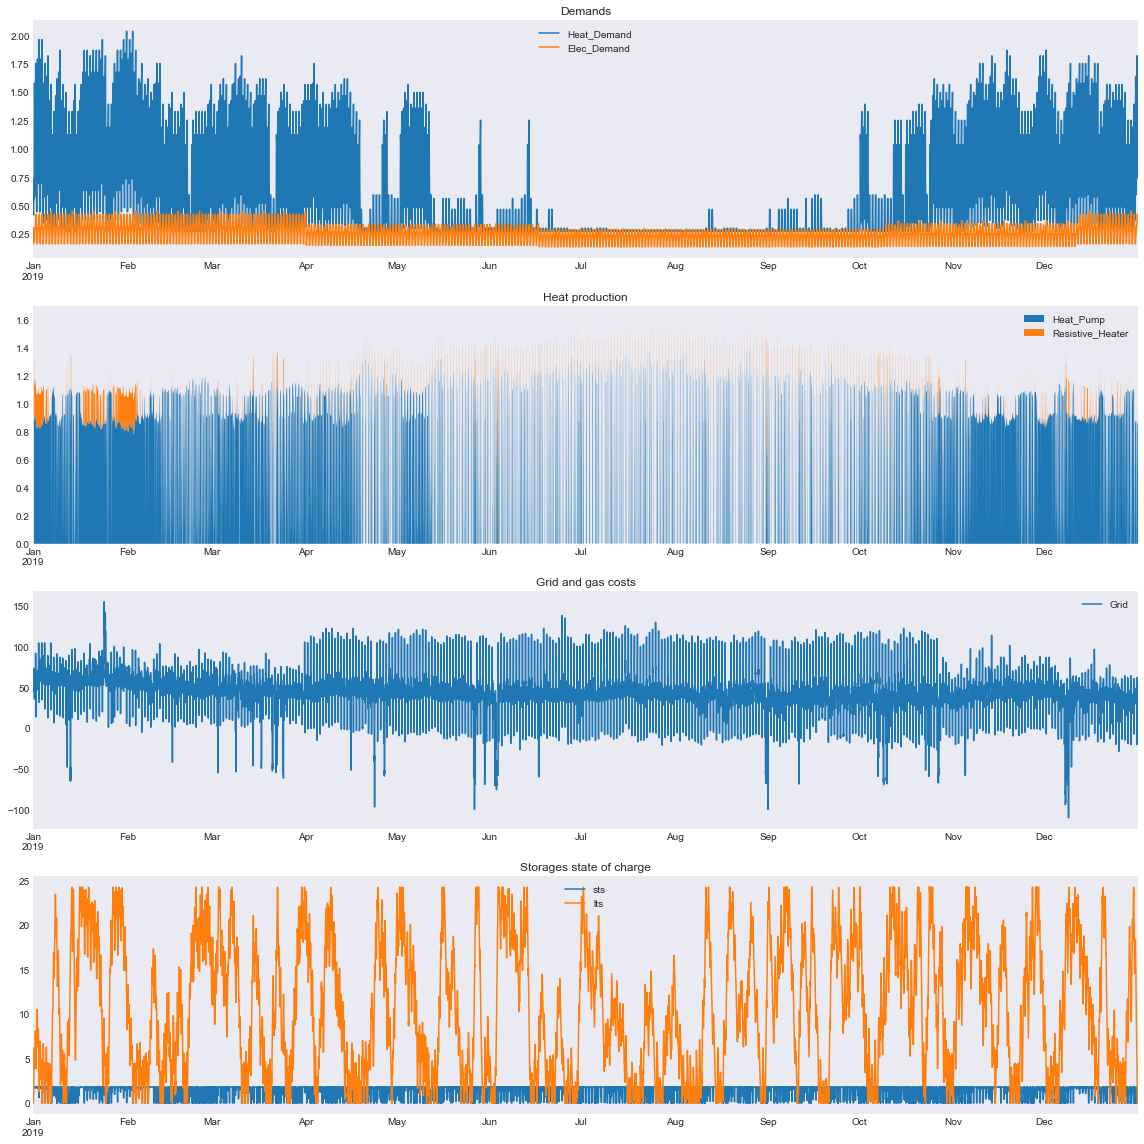

In [33]:
CurtailedWind.network.generators_t.p['Heat_Pump'] = CurtailedWind.network.links_t.p1.Heat_Pump * -1
CurtailedWind.network.generators_t.p['Resistive_Heater'] = CurtailedWind.network.links_t.p1.Resistive_Heater * -1
# ScotBord.network.generators_t.marginal_cost['Gas_Boiler'] = ScotBord.network.generators.marginal_cost.Gas_Boiler

fig, axs = plt.subplots(4, 1, figsize=(16, 16))

CurtailedWind.network.loads_t.p.rename_axis('').plot(ax=axs[0], title='Demands')
CurtailedWind.network.generators_t.p.rename_axis('').drop(columns=['Grid']).plot.area(ax=axs[1], linewidth=0, title='Heat production')
CurtailedWind.network.generators_t.marginal_cost.rename_axis('').plot(ax=axs[2], title='Grid and gas costs')
CurtailedWind.network.stores_t.e.rename_axis('').plot(ax=axs[3], title='Storages state of charge')

for ax in axs:
    ax.legend()
plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'Heat production'}>

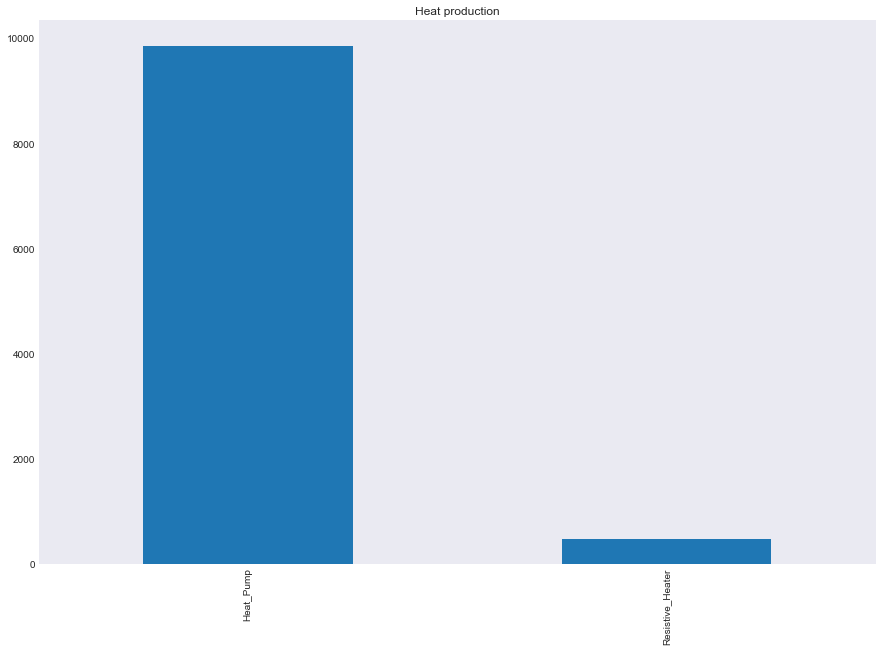

In [34]:
CurtailedWind.network.generators_t.p.rename_axis('').drop(columns=['Grid']).sum().plot.bar(figsize=(15,10), title='Heat production')

In [35]:
CurtailedWind.carbon_calculator(CurtailedWind.network.generators_t.p.Grid)
CurtailedWind.total_carbon_emissions = CurtailedWind.carbon_emissions.sum().round(2)
CurtailedWind.total_carbon_emissions

544290.83

In [36]:
CurtailedWind.total_costs = CurtailedWind.network.objective + CurtailedWind.network.objective_constant
CurtailedWind.total_costs

559153.9144744873

Capex £

In [37]:
CurtailedWind.capex = (CurtailedWind.network.links.p_nom_opt.Resistive_Heater * CurtailedWind.network.links.capital_cost.Resistive_Heater +
                       CurtailedWind.network.links.p_nom_opt.Heat_Pump * CurtailedWind.network.links.capital_cost.Heat_Pump +
                       CurtailedWind.network.stores.e_nom_opt.sts * CurtailedWind.network.stores.capital_cost.sts +
                       CurtailedWind.network.stores.e_nom_opt.lts * CurtailedWind.network.stores.capital_cost.lts)
CurtailedWind.capex

209520.68818908435

Opex £

In [38]:
CurtailedWind.opex = CurtailedWind.total_costs - CurtailedWind.capex
CurtailedWind.opex

349633.22628540295

## Compare scenarios

<AxesSubplot:>

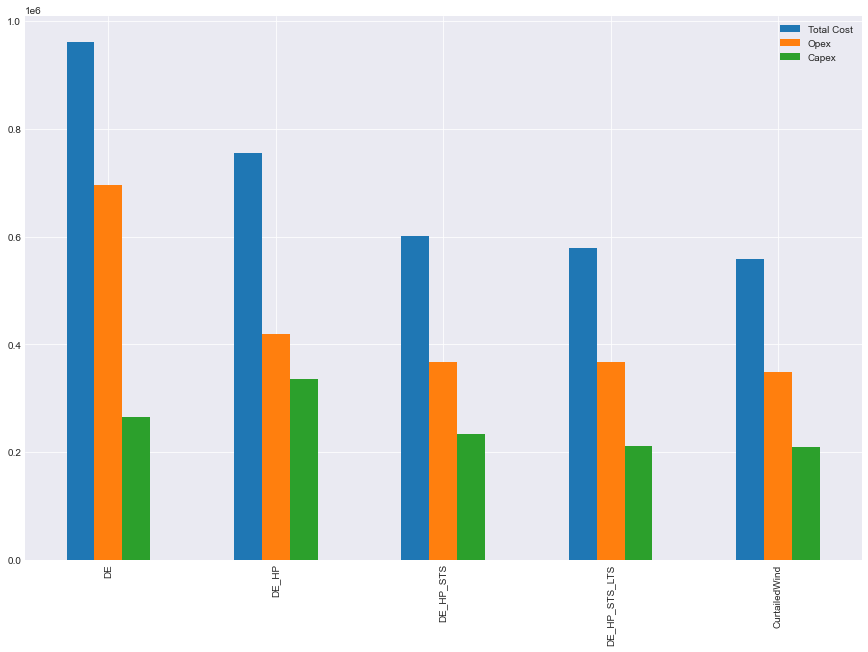

In [39]:
total_costs = [DE.total_costs, DE_HP.total_costs,
               DE_HP_STS.total_costs, DE_HP_STS_LTS.total_costs,
               CurtailedWind.total_costs]

opex = [DE.opex, DE_HP.opex,
        DE_HP_STS.opex, DE_HP_STS_LTS.opex,
        CurtailedWind.opex]

capex = [DE.capex, DE_HP.capex,
         DE_HP_STS.capex, DE_HP_STS_LTS.capex,
         CurtailedWind.capex]

df_compare = pd.DataFrame(data=[total_costs, opex, capex]).T#
df_compare.columns = ['Total Cost', 'Opex', 'Capex']
df_compare.index = ['DE', 'DE_HP', 'DE_HP_STS', 'DE_HP_STS_LTS', 'CurtailedWind']
df_compare.plot.bar(figsize=(15,10), grid=True)

1.0523627332690548


<AxesSubplot:>

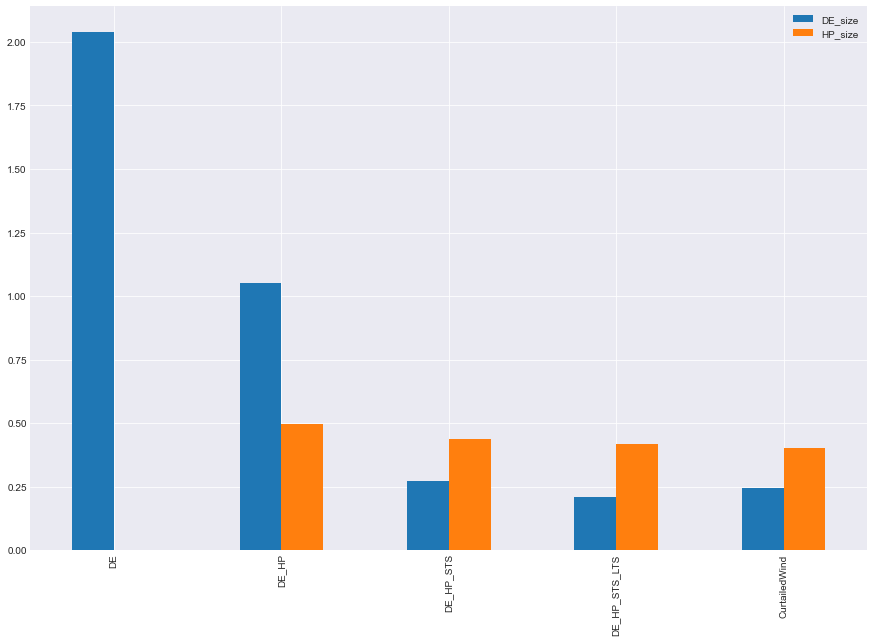

In [40]:
DE_size = [DE.network.links.p_nom_opt.Resistive_Heater, DE_HP.network.links.p_nom_opt.Resistive_Heater,
           DE_HP_STS.network.links.p_nom_opt.Resistive_Heater, DE_HP_STS_LTS.network.links.p_nom_opt.Resistive_Heater,
           CurtailedWind.network.links.p_nom_opt.Resistive_Heater]
print(DE_HP.network.links.p_nom_opt.Resistive_Heater)

HP_size = [0, DE_HP.network.links.p_nom_opt.Heat_Pump,
           DE_HP_STS.network.links.p_nom_opt.Heat_Pump, DE_HP_STS_LTS.network.links.p_nom_opt.Heat_Pump,
           CurtailedWind.network.links.p_nom_opt.Heat_Pump]

df_compare_sizes = pd.DataFrame(data=[DE_size, HP_size]).T#
df_compare_sizes.columns = ['DE_size', 'HP_size']
df_compare_sizes.index = ['DE', 'DE_HP', 'DE_HP_STS', 'DE_HP_STS_LTS', 'CurtailedWind']
df_compare_sizes.plot.bar(figsize=(15,10), grid=True)

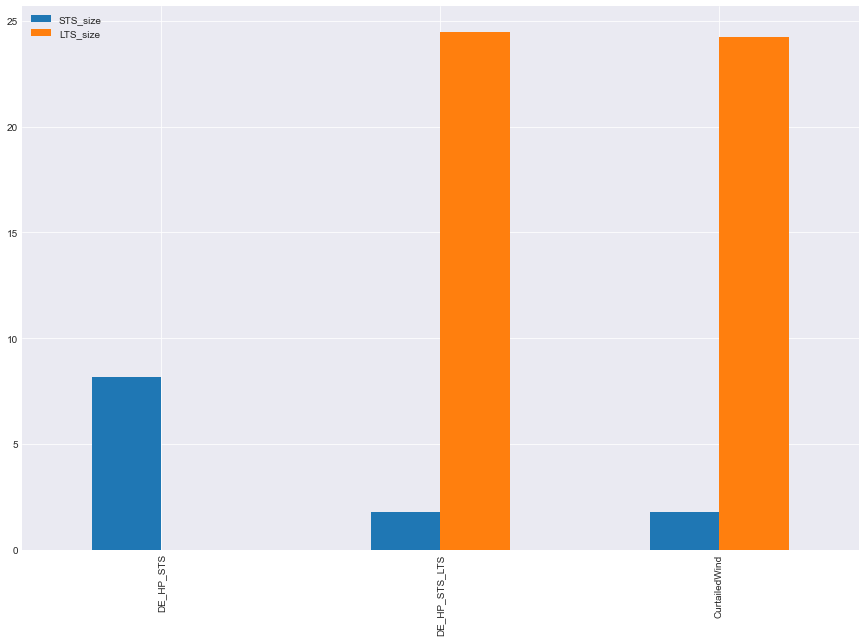

In [41]:
STS_size = [0, 0,
            DE_HP_STS.network.stores.e_nom_opt.sts, DE_HP_STS_LTS.network.stores.e_nom_opt.sts,
            CurtailedWind.network.stores.e_nom_opt.sts]

LTS_size = [0, 0,
            0, DE_HP_STS_LTS.network.stores.e_nom_opt.lts,
            CurtailedWind.network.stores.e_nom_opt.lts]

df_compare_s_sizes = pd.DataFrame(data=[STS_size, LTS_size]).T#
df_compare_s_sizes.columns = ['STS_size', 'LTS_size']
df_compare_s_sizes.index = ['DE', 'DE_HP', 'DE_HP_STS', 'DE_HP_STS_LTS', 'CurtailedWind']
df_compare_s_sizes.drop(index=['DE', 'DE_HP']).plot.bar(figsize=(15,10), grid=True).legend(loc='upper left')

In [42]:
CurtailedWind.network.generators_t.marginal_cost.mean()

Grid    42.890083
dtype: float64

In [43]:
DE_HP_STS_LTS.network.generators_t.marginal_cost.mean()

Grid    44.407602
dtype: float64

<AxesSubplot:>

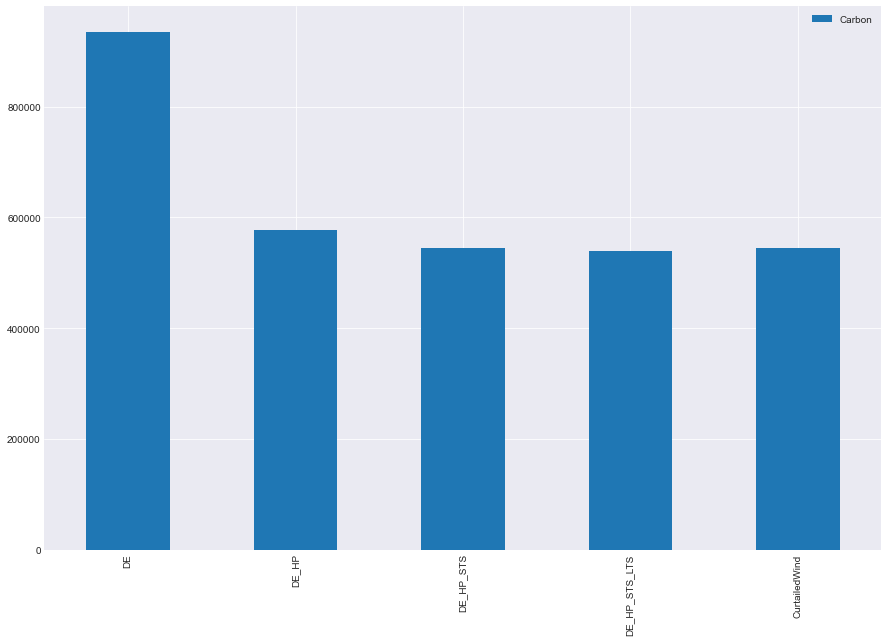

In [44]:
# check the carbon stuff
carbon_emissions = [DE.total_carbon_emissions, DE_HP.total_carbon_emissions,
                    DE_HP_STS.total_carbon_emissions, DE_HP_STS_LTS.total_carbon_emissions,
                    CurtailedWind.total_carbon_emissions]

df_compare_carbon = pd.DataFrame(data=[carbon_emissions]).T
df_compare_carbon.columns = ['Carbon']
df_compare_carbon.index = ['DE', 'DE_HP', 'DE_HP_STS', 'DE_HP_STS_LTS', 'CurtailedWind']
df_compare_carbon.plot.bar(figsize=(15,10), grid=True)

### Metrics

Fuel poverty
* Capex
* Opex
* Total cost

Net zero
* Carbon emissions

Network
* Curtailed energy used
* Percentage of crystal rig II used
* Peak electrical load
